In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from google.cloud import bigquery

# Fetch Credentials - I created a key then literally dragged/dropped it to /content on google colab 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'local-receiver-341803-9e38525e7b40.json'

# Build BigQuery Client
client = bigquery.Client()

In [26]:
#Get the dataset

# Query for Position Histories from BigQuery - change limit after we know it works
QUERY = ('SELECT lastTrainReporting.positionHistoryList FROM `local-receiver-341803.testTrainEvents.train-event-data` LIMIT 500')
query_job = client.query(QUERY)

# Wait for job to finish
rows = query_job.result()

print("Num rows fetched: " + str(rows.total_rows))




Num rows fetched: 500


In [27]:
# Create the data frame - should have a timestamp in it

# Fetch each position time and milepost
positionMilepostTimesDataFrame = pd.DataFrame()

# For each returned record
for row in rows:
    # Scan each position history
    for positionHistory in row.get('positionHistoryList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in regression model
        #positionTime = positionHistory.get('positionTime').timestamp()
        positionTime = positionHistory.get('positionTime')

        # How fast the train is traveling
        speedMPH = positionHistory.get('speedMPH')

        # Milepost location information
        milepostLocation = positionHistory.get('milepostLocation')
        # The unique identifier of the subdivision
        subdivisionId = milepostLocation.get('subdivisionId')
        # The unique identifier fo the milepost
        milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

        # Construct new dataframe record
        dataframeRow = {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
                        'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}

        # Append the row to the data frame.
        positionMilepostTimesDataFrame = positionMilepostTimesDataFrame.append(dataframeRow, ignore_index = True)


#Return an item and drop from frame
date_time = pd.to_datetime(positionMilepostTimesDataFrame.pop("PositionTime"), format='%Y-%m-%d %H:%M:%S')

print("date time: \n" + str(date_time))

print("cols: " + str(positionMilepostTimesDataFrame.columns))

positionMilepostTimesDataFrame.head()

date time: 
0      2022-04-02 01:55:06+00:00
1      2022-04-02 01:54:08+00:00
2      2022-04-02 01:53:34+00:00
3      2022-04-02 01:52:49+00:00
4      2022-04-02 01:51:51+00:00
                  ...           
2495   2022-04-05 03:24:18+00:00
2496   2022-04-05 03:19:18+00:00
2497   2022-04-05 03:19:11+00:00
2498   2022-04-05 03:14:19+00:00
2499   2022-04-05 03:09:19+00:00
Name: PositionTime, Length: 2500, dtype: datetime64[ns, UTC]
cols: Index(['SpeedMPH', 'SubdivisionId', 'MilepostNumber'], dtype='object')


,SpeedMPH,SubdivisionId,MilepostNumber
0,-11.0,106.0,766.9261
1,-10.0,595.0,279.0362
2,-9.0,595.0,279.1244
3,-7.0,595.0,279.2209
4,-3.0,595.0,279.3100


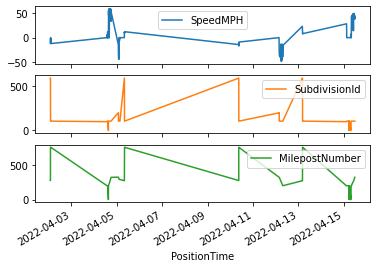

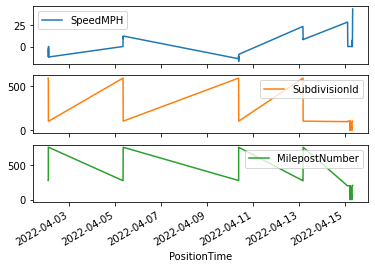

In [28]:
#Evolution of Features over time

plot_cols = ['SpeedMPH', 'SubdivisionId', 'MilepostNumber']
plot_features = positionMilepostTimesDataFrame[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = positionMilepostTimesDataFrame[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [29]:
# Inspect and clean up - look at statistics of dataset

positionMilepostTimesDataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SpeedMPH,2500.0,8.4508,33.058420,-48.0,-23.500000,0.0000,42.000000,58.0000
SubdivisionId,2500.0,113.4484,62.962117,0.0,106.000000,106.0000,106.000000,595.0000
MilepostNumber,2500.0,282.3534,122.677411,0.0,222.781125,261.6436,298.529025,766.9261


In [ ]:
# Data clean up - what data do we want to clean up now? For example, negative speeds??

# Leaving this section blank for now

Text(0.5, 1.0, 'Time of day signal thing')

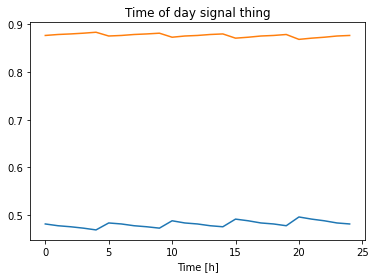

In [30]:
# Date time updates

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

positionMilepostTimesDataFrame['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
positionMilepostTimesDataFrame['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
positionMilepostTimesDataFrame['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
positionMilepostTimesDataFrame['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(positionMilepostTimesDataFrame['Day sin'])[:25])
plt.plot(np.array(positionMilepostTimesDataFrame['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal thing')

In [ ]:
# Do we need to do a fast fourier transform? Maybe not.

In [31]:
# Finally get to some training things - split the data

column_indices = {name: i for i, name in enumerate(positionMilepostTimesDataFrame.columns)}

n = len(positionMilepostTimesDataFrame)

train_df = positionMilepostTimesDataFrame[0:int(n*0.7)]
val_df = positionMilepostTimesDataFrame[int(n*0.7):int(n*0.9)]
test_df = positionMilepostTimesDataFrame[int(n*0.9):]

num_features = positionMilepostTimesDataFrame.shape[1]

In [32]:
# Now we normalize the data - required before training a neural network. 

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



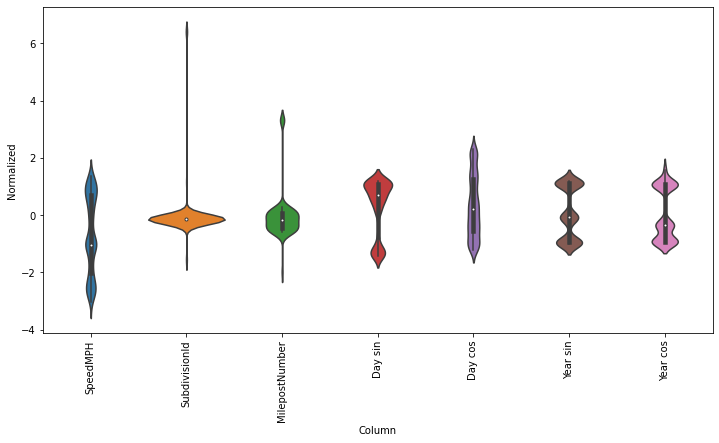

In [33]:
# View distribution of the features - look for obvious errors here

df_std = (positionMilepostTimesDataFrame - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(positionMilepostTimesDataFrame.keys(), rotation=90)

In [34]:
# Data Windowing - done for reuse and for making prediction x hours into the future given y hours of history
# Main features: width of input and label windows, time offset between them, which features are used as inputs, labels or both


class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [35]:
# Now add code to create 2 windows  (note: try different columns here)

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['MilepostNumber'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['MilepostNumber']

In [36]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['MilepostNumber'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['MilepostNumber']

In [37]:
# Do some window splitting

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [38]:
# Make use of the window splitting feature
# Note you need enough data for this to work

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [41]:
# Now, plot!

w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='MilepostNumber', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

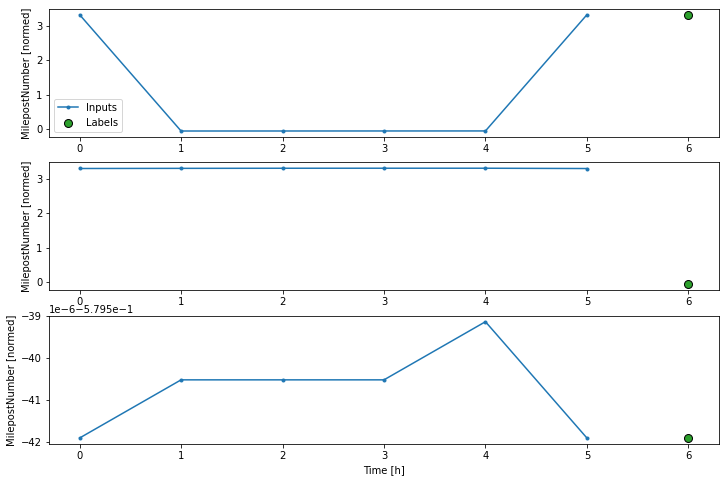

In [42]:
# Here is where we show the plot

w2.plot()

In [43]:
# Make some datasets

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [44]:
# Add properties to the datasets

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [45]:
# The window generator gives us access to the tensor flow dataset objects for easy iteration 

# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [46]:
# let's look at concrete batches

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)
